In [1]:
using Pkg; Pkg.activate("../../../FermiCG/")
using FermiCG
using PyCall
using Plots
using LinearAlgebra
using Printf
using JLD2

  Activating project at `~/code/FermiCG`


In [2]:
#molecule = "
#He 0.00000000 0.00000000 0.00000000
#He 1.41421356 0.00000000 0.00000000
#He 0.00000000 1.41421356 0.00000000
#He 1.41421356 1.41421356 0.00000000
#He 0.70710678 0.70710678 1.00000000
#He 0.70710678 0.70710678 -1.00000000
#"
#molecule = "
#He 0.00000000 0.00000000 0.00000000
#He 2.12132035 0.00000000 0.00000000
#He 0.00000000 2.12132035 0.00000000
#He 2.12132034 2.12132034 0.00000000
#He 1.06066017 1.06066017 1.50000000
#He 1.06066017 1.06066017 -1.50000000
#"
molecule = "
He       0.0000000000000000       0.0000000000000000       0.0000000000000000
He       3.8890872900000004       0.0000000000000000       0.0000000000000000
He       0.0000000000000000       3.8890872900000004       0.0000000000000000
He       3.8890872900000004       3.8890872900000004       0.0000000000000000
He       1.9445436450000002       1.9445436450000002       2.7500000000000000
He       1.9445436450000002       1.9445436450000002      -2.7500000000000000
"
atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

basis = "aug-cc-pvdz"

# Create FermiCG.Molecule type
mol     = Molecule(0, 1, atoms,basis);

pyscf = pyimport("pyscf")

n_steps = 35
step_size = .05

pymol_init = pyscf.gto.Mole(atom=molecule,
                            symmetry = false, spin =0,charge=0,
                            basis = basis)
pymol_init.build()

PyObject <pyscf.gto.mole.Mole object at 0x7fc6b0c596d0>

In [3]:
io = open("traj.xyz", "w");
energies_ground = []
energies_t1 = []
energies_t2 = []
energies_t3 = []
energies_t4 = []
energies_t5 = []
energies_t6 = []

energies_s1 = []
energies_s2 = []
energies_s3 = []
energies_s4 = []
energies_s5 = []
energies_s6 = []

energies_t7 = []
energies_t8 = []
energies_t9 = []
energies_t10 = []
energies_t11 = []
energies_t12 = []
pt2_energies = []

lo = pyimport("pyscf.lo.orth")
tools = pyimport("pyscf.tools")
fcidump = pyimport("pyscf.tools.fcidump");

In [35]:
pymol = deepcopy(pymol_init)
#scale = 1+1*step_size
#scale = 1
#move to smaller geometry
#xyz = @sprintf("%5i\n\n", length(mol.atoms))
#tmp = []

#for a in mol.atoms
#    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
#    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
#end

#pymol.atom = tmp
#pymol.build()

#mf = pyscf.scf.RHF(pymol).run()
#@time s = mf.get_ovlp(pymol)
#@time s2 = pymol.intor_symmetric("int1e_ovlp")
#lo_ao = lo.orth_ao(mf, "lowdin", pre_orth_ao=nothing)
#lo_ao = lo.lowdin(s)
#tools.fcidump.from_mo(pymol, "fcidump.he06_oct", lo_ao)

#Can just read in pyscf dump file for integrals (once you have already run an scf calculation)
#ctx = fcidump.read("fcidump.he06_oct");
#h = ctx["H1"];
#g = ctx["H2"];
#ecore = ctx["ECORE"];
#g = pyscf.ao2mo.restore("1", g, size(h,2))

#This one below was not working. Error: setfield! immutable struct of type InCoreInts cannot be changed
#ints = InCoreInts(ecore,h,g);

#Define clusters and intial Fock space for inital CMF calc for 9 orbs each He
#clusters_in = [(1:9),(10:18), (19:27), (28:36), (37:45), (46:54)]

#Define clusters and intial Fock space for inital CMF calc for 5 orbs each He
#init_fspace = [(1,1),(1,1),(1,1),(1,1),(1,1),(1,1)]
#rdm1 = zeros(size(ints.h1))
#na=6
#nb=6

#Define clusters now using FermiCG code
#clusters = [Cluster(i,collect(clusters_in[i])) for i = 1:length(clusters_in)]
#display(clusters)
        
#do a CMF calculation to optimize cluster orbitals
#e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1, rdm1, max_iter_oo=100, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
#FermiCG.pyscf_write_molden(mol,lo_ao*U, filename="cmf.molden");

#U_old = U
#C_old = lo_ao*U
#lo_ao_old = lo_ao
#Da_old = Da
#Db_old = Db
#@save "start_var.jld2" U_old C_old lo_ao_old Da_old Db_old
@load "start_var.jld2"

for R in 1:n_steps
    println("\n*********** Iteration: ", R, " *************")
    #pymol = deepcopy(pymol_init)
    scale = 1+R*step_size
    #scale = 1
    
    #move to smaller geometry
    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
    end
    
    #move to larger geometry
    #for a in mol.atoms
    #    push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
    #    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    #end
    
    pymol.atom = tmp
    pymol.build()
    println(xyz)
    write(io, xyz);

    mf = pyscf.scf.RHF(pymol).run()
    s = mf.get_ovlp(pymol)
    lo_ao = lo.lowdin(s)
    #Symmetric Orthogonalization
    #For reference C_old = lo_ao*U, lo_ao at geom1 and U is from cmf from geom1,
    # s is at geom2
    display(lo_ao_old'*s*lo_ao_old)
    S_ab = lo_ao_old'*lo_ao
    val, vec = eigen(S_ab)
    values = Diagonal(val.^(-1/2))
    Sab_half  = vec'*values*vec
    
    P = C_old'*s*C_old
    display(P)
    error("stop")
    val, vec = eigen(P)
    values = Diagonal(val.^(-1/2))
    P_half  = vec'*values*vec
    lo_new = P_half'*lo_ao*P_half
    #C_new = lo_new*U_old
    
    C_new = P_half'*C_old*P_half
    display(C_new'*s*C_new)
    error("here")
    #C_new = C_old
   
    #C_new = lo_ao*U_old
    #println("size of Lowdin ortho AO's:", size(lo_ao))
    
    #val, vec = eigen(s)
    #values = Diagonal(val.^(-1/2))
    #S_half  = vec*values*vec'
    
    #write fci dump file from the modified mo coefficients
    tools.fcidump.from_mo(pymol, "fcidump.he06_oct", C_new)
    
    #Can just read in pyscf dump file for integrals (once you have already run an scf calculation)
    ctx = fcidump.read("fcidump.he06_oct");
    h = ctx["H1"];
    g = ctx["H2"];
    ecore = ctx["ECORE"];
    g = pyscf.ao2mo.restore("1", g, size(h,2))

    #This one below was not working. Error: setfield! immutable struct of type InCoreInts cannot be changed
    ints = InCoreInts(ecore,h,g);
    
    #Define clusters and intial Fock space for inital CMF calc for 9 orbs each He
    clusters_in = [(1:9),(10:18), (19:27), (28:36), (37:45), (46:54)]

    #Define clusters and intial Fock space for inital CMF calc for 5 orbs each He
    init_fspace = [(1,1),(1,1),(1,1),(1,1),(1,1),(1,1)]
    rdm1 = zeros(size(ints.h1))
    na=6
    nb=6

    #Define clusters now using FermiCG code
    clusters = [Cluster(i,collect(clusters_in[i])) for i = 1:length(clusters_in)]
    #display(clusters)
        
    #do a CMF calculation to optimize cluster orbitals
    e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1, rdm1, max_iter_oo=200, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
    #e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, Da_old, Db_old, max_iter_oo=200, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
    #FermiCG.pyscf_write_molden(mol,lo_ao*U, filename="cmf.molden");
    
    U_old = U
    C_old = C_new*U
    lo_ao_old = lo_ao
    Da_old = Da
    Db_old = Db
    #rotate the integrals by the cmf calculation
    ints = FermiCG.orbital_rotation(ints, U);
    max_roots = 40

    #Build Cluster Basis (delta n is here)
    cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, delta_elec=2, verbose=1, max_roots=max_roots, init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);

    #@save "scan_after_cmf.jld2" ints Da Db e_cmf cluster_bases clusters init_fspace

    #Build Clustered Operator
    cluster_ham = FermiCG.extract_ClusteredTerms(ints, clusters);
    
    #Build Cluster Operators
    cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);
    FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db);
    
    #Need to find reference state 
    ref_fock = FermiCG.FockConfig(init_fspace)
    nroots = 19
    #ci_vector = FermiCG.TPSCIstate(clusters, ref_fock, R=nroots)
    ci_vector = FermiCG.TPSCIstate(clusters, FermiCG.FockConfig(init_fspace), R=nroots);
    #ci_vector = FermiCG.ClusteredState(clusters, ref_fock, R=nroots);
    #Need to find the automated way to define these other excited configs away from ref state, example is to large
    #to do by hand
    #probably something to do with building p spaces and q spaces
    
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([2,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,2,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,2,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,2,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,2,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,2])] = zeros(Float64,nroots)
    
    ci_vector[ref_fock][ClusterConfig([3,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,3,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,3,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,3,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,3,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,3])] = zeros(Float64,nroots)
    
    ci_vector[ref_fock][ClusterConfig([4,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,4,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,4,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,4,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,4,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,4])] = zeros(Float64,nroots)

    FermiCG.eye!(ci_vector)
    #display(ci_vector)

    #for thresh_cipsi in thresh_list
    e0, v0 = FermiCG.tpsci_ci(ci_vector, cluster_ops, cluster_ham,
                              thresh_cipsi=1e-3, # Threshold for adding to P-space
                              #thresh_cipsi=thresh_cipsi, # Threshold for adding to P-space
                              thresh_foi=1e-2,    # Threshold for keeping terms when defining FOIS
                              thresh_asci=1e-1,     # Threshold of P-space configs to search from
                              max_iter=10);

    @time e2 = FermiCG.compute_pt2_energy(v0, cluster_ops, cluster_ham, thresh_foi=1e-8)
    #name = "eq_tpsci_results"*string(0.001)*".jld2"
    #@save name e0 e2 v0 ecore
    
    println()
    println("	*======TPSCI results======*")
    @printf("TCI Thresh: %8.6f  Dim:%8d\n",1e-2,size(v0)[1])
    println()
    @printf("TCI %5s %12s %12s\n", "Root", "E(0)", "E(2)") 
    for r in 1:nroots
        @printf("TCI %5s %12.8f %12.8f\n",r, e0[r] + ecore, e0[r] + e2[r] + ecore)
        display(v0,thresh=1e-4,root=r)
    end
    #end
    
    push!(energies_ground, e0[1]+ecore)
    push!(energies_t1, e0[2]+ecore)
    push!(energies_t2, e0[3]+ecore)
    push!(energies_t3, e0[4]+ecore)
    push!(energies_t4, e0[5]+ecore)
    push!(energies_t5, e0[6]+ecore)
    push!(energies_t6, e0[7]+ecore)
    
    push!(energies_s1, e0[8]+ecore)
    push!(energies_s2, e0[9]+ecore)
    push!(energies_s3, e0[10]+ecore)
    push!(energies_s4, e0[11]+ecore)
    push!(energies_s5, e0[12]+ecore)
    push!(energies_s6, e0[13]+ecore)

    push!(energies_t7, e0[14]+ecore)
    push!(energies_t8, e0[15]+ecore)
    push!(energies_t9, e0[16]+ecore)
    push!(energies_t10, e0[17]+ecore)
    push!(energies_t11, e0[18]+ecore)
    push!(energies_t12, e0[19]+ecore)

    push!(pt2_energies, e2)
end


*********** Iteration: 1 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       3.7038926571428572       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       3.7038926571428572       0.0000000000000000 
    He       3.7038926571428572       3.7038926571428572       0.0000000000000000 
    He       1.8519463285714286       1.8519463285714286       2.6190476190476191 
    He       1.8519463285714286       1.8519463285714286      -2.6190476190476191 

converged SCF energy = -17.1342375747563


54×54 Matrix{Float64}:
  0.999898      0.000425106  -0.00206012   …  -0.000456034   0.000437707
  0.000425106   0.998487      0.00904544       0.00378657   -0.00434589
 -0.00206012    0.00904544    0.968858        -0.0114588     0.0130854
  8.73922e-5   -0.000333475   0.00133934       0.000636596  -0.0010467
  8.73922e-5   -0.000333475   0.00133934       0.000700491  -0.0010467
 -2.41691e-16   1.22581e-16   8.48868e-17  …  -0.0011194     0.00133687
 -0.000546593   0.00241877   -0.00730875      -0.00263193    0.00439777
 -0.000546593   0.00241877   -0.00730875      -0.0032239     0.00439777
 -1.58012e-16  -1.27986e-16   2.77175e-16      0.00487663   -0.00585583
 -2.07147e-5    0.000816464   0.000728254     -0.000456034   0.000437707
  0.000816464  -0.0075745     0.00152036   …   0.00378657   -0.00434589
  0.000728254   0.00152036    0.0281544       -0.0114588     0.0130854
 -8.33295e-5   -0.000231215   0.0021041       -0.000636596   0.0010467
  ⋮                                        ⋱

54×54 Matrix{Float64}:
  0.999897      0.000366862  -0.00231157   …  -0.000451298   0.000402181
  0.000366862   0.998679      0.0100497        0.00377092   -0.004216
 -0.00231157    0.0100497     0.968088        -0.0114404     0.0132105
  9.15912e-5   -0.000338703   0.00132483       0.000641823  -0.00105484
  9.15911e-5   -0.000338703   0.00132483       0.000686071  -0.00105484
 -2.57484e-11   8.64836e-11  -2.0518e-10   …  -0.00111945    0.00133125
 -0.000633614   0.00263267   -0.00707736      -0.00267845    0.004494
 -0.000633615   0.00263267   -0.00707736      -0.00312281    0.004494
  8.28022e-12  -2.62516e-11   3.10197e-11      0.00487661   -0.00580126
 -9.66416e-6    0.000757088   0.000697847     -0.000451298   0.000402181
  0.000757088  -0.00739345    0.00178696   …   0.00377092   -0.004216
  0.000697847   0.00178696    0.0278252       -0.0114404     0.0132105
 -8.35329e-5   -0.000227645   0.00210963      -0.000641823   0.00105484
  ⋮                                        ⋱     

LoadError: stop

In [154]:
@save "nb_scan_energies_triplet.jld2" energies_ground energies_t1 energies_t2 energies_t3 energies_t4 energies_t5 energies_t6
@save "nb_scan_energies_singlet.jld2" energies_s1 energies_s2 energies_s3 energies_s4 energies_s5 energies_s6
@save "nb_scan_energies_second_triple.jld2" energies_t7 energies_t8 energies_t9 energies_t10 energies_t11 energies_t12
@save "nb_pt2_energies.jld2" pt2_energies

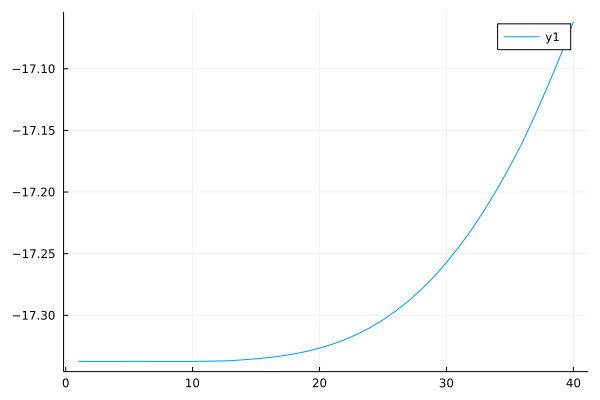

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
┌ Warning: Module Cairo_jll with build ID 349201218297556 is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9].
└ @ Base loading.jl:1124
┌ Info: Precompiling Qt5Base_jll [ea2cea3b-5b76-57ae-a6ef-0a8af62496e1]
└ @ Base loading.jl:1423
┌ Warning: Module Fontconfig_jll with build ID 349203755823667 is missing from the cache.
│ This may mean Fontconfig_jll [a3f928ae-7b40-5064-980b-68af3947d34b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing Qt5Base_jll [ea2cea3b-5b76-57ae-a6ef-0a8af62496e1].
└ @ Base loading.jl:1124


In [155]:
plot(energies_ground, energies_t1 energies_t2 energies_t3 energies_t4 energies_t5 energies_t6

In [156]:
display(energies_ground)

40-element Vector{Any}:
 -17.33737605400575
 -17.33740487020998
 -17.337418456133072
 -17.337415584601096
 -17.337376325879166
 -17.33737605400575
 -17.337403836105224
 -17.337418456133022
 -17.337415584600905
 -17.33739258612745
 -17.337284472187918
 -17.33708924451954
 -17.33676751150621
   ⋮
 -17.26892995203632
 -17.257175653424063
 -17.244302944686513
 -17.23017520616588
 -17.214521086883128
 -17.19757412703656
 -17.179271370593515
 -17.159453914061086
 -17.13726418895807
 -17.113836626079966
 -17.08894685798302
 -17.06206120433742

In [164]:
println(energies_t6)

Any[-16.595597906424494, -16.59284842992846, -16.589617048201646, -16.585536109240998, -16.581544577272624, -16.595597906424494, -16.592840376183595, -16.58961785089535, -16.585536032757616, -16.58199812031938, -16.57729080427074, -16.573909892518856, -16.574009106963672, -16.56789571465427, -16.567148179723667, -16.565765525139962, -16.561946208576813, -16.558489030529017, -16.556577119468322, -16.55436421471482, -16.550257517118474, -16.546039413231377, -16.542713452895377, -16.538600262396695, -16.534154349143527, -16.527995403106853, -16.520849459287444, -16.51812419614894, -16.516312600090952, -16.51047302758495, -16.504513723106083, -16.50052367519742, -16.491843611645972, -16.482773689756037, -16.474326094455325, -16.464091741262838, -16.44815261028279, -16.433397122810568, -16.41526951490997, -16.39422511187473]
